In [1]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
import plotting

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/jet_plots/Oct21"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"


In [5]:
jetnet.datasets.JetNet.all_particle_features


['etarel', 'phirel', 'ptrel', 'mask']

In [4]:
truth_jets_pf, _ = JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[1.0, 0, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [72]:
# efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
# np.save("efps", efps)


In [9]:
efps_true = np.load(f"{data_dir}/efps_true.npy")
pnet_activations_true = np.load(f"{data_dir}/pnet_activations_true.npy")


In [6]:
from typing import OrderedDict
from coffea.lookup_tools.dense_lookup import dense_lookup

mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing Tail")),
    ]
)


In [9]:
# np.random.seed(4)

# pf_dists = OrderedDict()

# pf_dists["all_smeared"] = (
#     truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
#     "Particle Features Smeared",
# )
# pf_dists["eta_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
#             truth_jets_pf[..., 1:],
#         ),
#         axis=-1,
#     ),
#     r"Particle $\eta^{rel}$ Smeared",
# )
# pf_dists["pt_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Smeared",
# )
# pf_dists["pt_shifted"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3]
#             * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Shifted",
# )


In [31]:
# with open("pf_dists.pkl", "wb") as f:
#     pickle.dump(pf_dists, f)


In [28]:
# efps = {
#     key: jetnet.utils.efps(jets, efpset_args=[("d<=", 4)]) for key, (jets, _) in pf_dists.items()
# }
#
# with open("efps_dict.pkl", "wb") as f:
#     pickle.dump(efps, f)


In [7]:
with open(f"{data_dir}/pf_dists.pkl", "rb") as f:
    pf_dists = pickle.load(f)

with open(f"{data_dir}/efps_dict.pkl", "rb") as f:
    efps = pickle.load(f)

pnet_activations = {}

for key in pf_dists:
    pnet_activations[key] = np.load(f"{data_dir}/pnet_activations_{key}.npy")

masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}


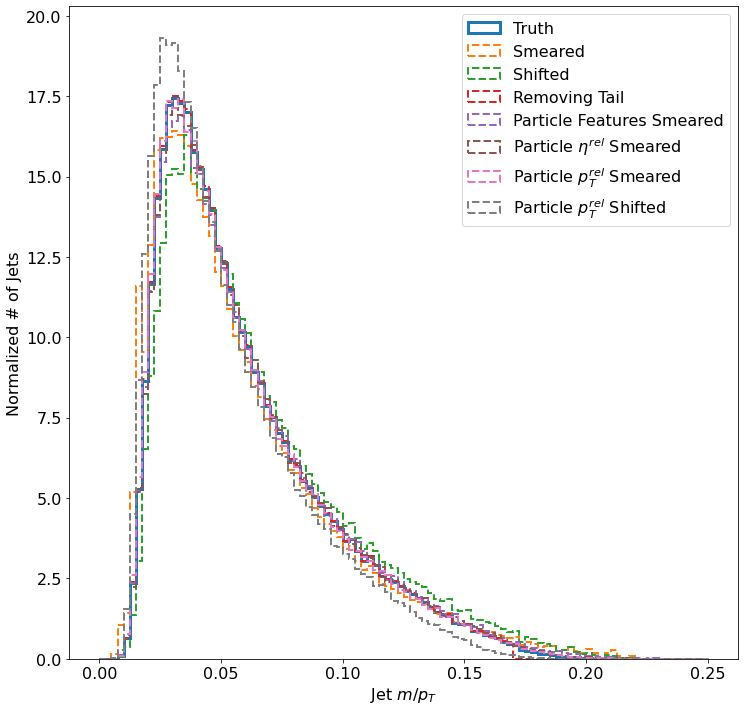

In [11]:
plt.figure(figsize=(12, 12))

bins = np.linspace(0, 0.25, 101)

_ = plt.hist(mass, bins, histtype="step", label="Truth", linewidth=3, density=True)
for weights, label in dists.values():
    if label == "Truth":
        continue
    
    _ = plt.hist(
        mass,
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        masses[key],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists.pdf", bbox_inches="tight")


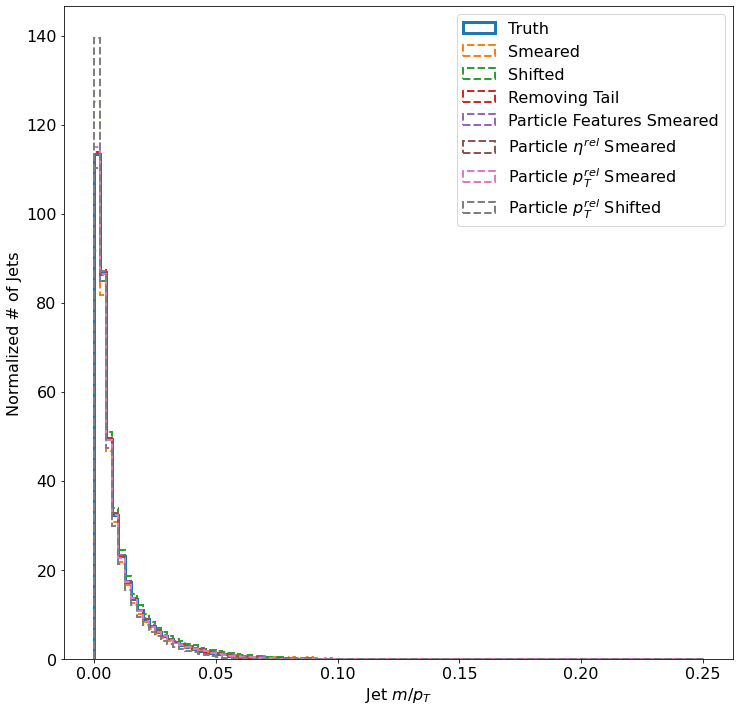

In [19]:
plt.figure(figsize=(12, 12))

# bins = np.linspace(0, 0.04, 101)
bins = np.linspace(0, 0.25, 101)
efp_index = 2

_ = plt.hist(
    efps_true[:, efp_index], bins, histtype="step", label="Truth", linewidth=3, density=True
)
for weights, label in dists.values():
    if label == "Truth":
        continue

    _ = plt.hist(
        efps_true[:, efp_index],
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        efps[key][:, efp_index],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists_efp.pdf", bbox_inches="tight")


In [10]:
num_samples = 150_000
sample_efps = OrderedDict()
sample_acts = OrderedDict()
sample_masses = OrderedDict()

np.random.seed(4)
true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_mass = mass[true_inds]
true_efps = efps_true[true_inds]
true_acts = pnet_activations_true[true_inds]

for key, (weights, _) in dists.items():
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_masses[key] = mass[inds]
    sample_efps[key] = efps_true[inds]
    sample_acts[key] = pnet_activations_true[inds]
    # np.save(f"../distorted_jets/{key}.npy", truth_jets_pf[inds])

for key in pf_dists:
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
    sample_masses[key] = masses[key][inds]
    sample_efps[key] = efps[key][inds]
    sample_acts[key] = pnet_activations[key][inds]
    # np.save(f"../distorted_jets/{key}.npy", pf_dists[key][0])


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [21]:
num_batches = 5

batch_sizes = {
    "w1m": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000],
    "fgd": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
}

metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4 Quadratic Unbiased Est.",
            ),
        ),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
    ]
)


In [30]:
measurements_w1m = OrderedDict()
mkey = "w1m"

for dkey in sample_masses:
    print(dkey)
    ms = []
    ts = []
    for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
        mean_std, timing = gen_metrics.multi_batch_evaluation(
            true_mass,
            sample_masses[dkey],
            num_batches,
            batch_size,
            gen_metrics.wasserstein1d,
            timing=True,
        )
        ms.append(mean_std)
        ts.append(timing)
    measurements_w1m[dkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


w1m: 100%|██████████| 18/18 [00:00<00:00, 30.99it/s] 


smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 30.63it/s] 


shifted


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.28it/s] 


tailcut


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.06it/s] 


all_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 32.87it/s] 


eta_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 32.98it/s] 


pt_smeared


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.72it/s] 


pt_shifted


w1m: 100%|██████████| 18/18 [00:00<00:00, 33.55it/s] 


In [31]:
if "measurements_efps" not in locals():
    measurements_efps = OrderedDict()

for dkey in sample_efps:
    print(dkey)
    if dkey not in measurements_efps:
        measurements_efps[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements_efps[dkey] and mkey != "fgd":  #
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_efps,
                sample_efps[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args
            )
            ms.append(mean_std)
            ts.append(timing)

        measurements_efps[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.99it/s]


smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.45it/s]


shifted


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


tailcut


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.33it/s]


all_smeared


fgd: 100%|██████████| 18/18 [00:02<00:00,  8.78it/s]


eta_smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


pt_smeared


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


pt_shifted


fgd: 100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


In [34]:
if "measurements_acts" not in locals():
    measurements_acts = OrderedDict()

for dkey in sample_acts:
    print(dkey)
    if dkey not in measurements_acts:
        measurements_acts[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (mkey in measurements_acts[dkey]) and mkey != "fgd":
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_acts,
                sample_acts[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args,
                normalise=False
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_acts[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


shifted


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


tailcut


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


all_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.02it/s]


eta_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]


pt_smeared


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]


pt_shifted


fgd: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]


In [41]:
# with open(f"{plot_dir}/measurements_w1m.pkl", "wb") as f:
#     pickle.dump(measurements_w1m, f)

# with open(f"{plot_dir}/measurements_efps.pkl", "wb") as f:
#     pickle.dump(measurements_efps, f)

# with open(f"{plot_dir}/measurements_acts.pkl", "wb") as f:
#     pickle.dump(measurements_acts, f)


In [24]:
measurements_dir = "../plots/jet_plots/Oct15"

with open(f"{measurements_dir}/measurements_w1m.pkl", "rb") as f:
    measurements_w1m = pickle.load(f)

with open(f"{measurements_dir}/measurements_efps.pkl", "rb") as f:
    measurements_efps = pickle.load(f)

with open(f"{measurements_dir}/measurements_acts.pkl", "rb") as f:
    measurements_acts = pickle.load(f)

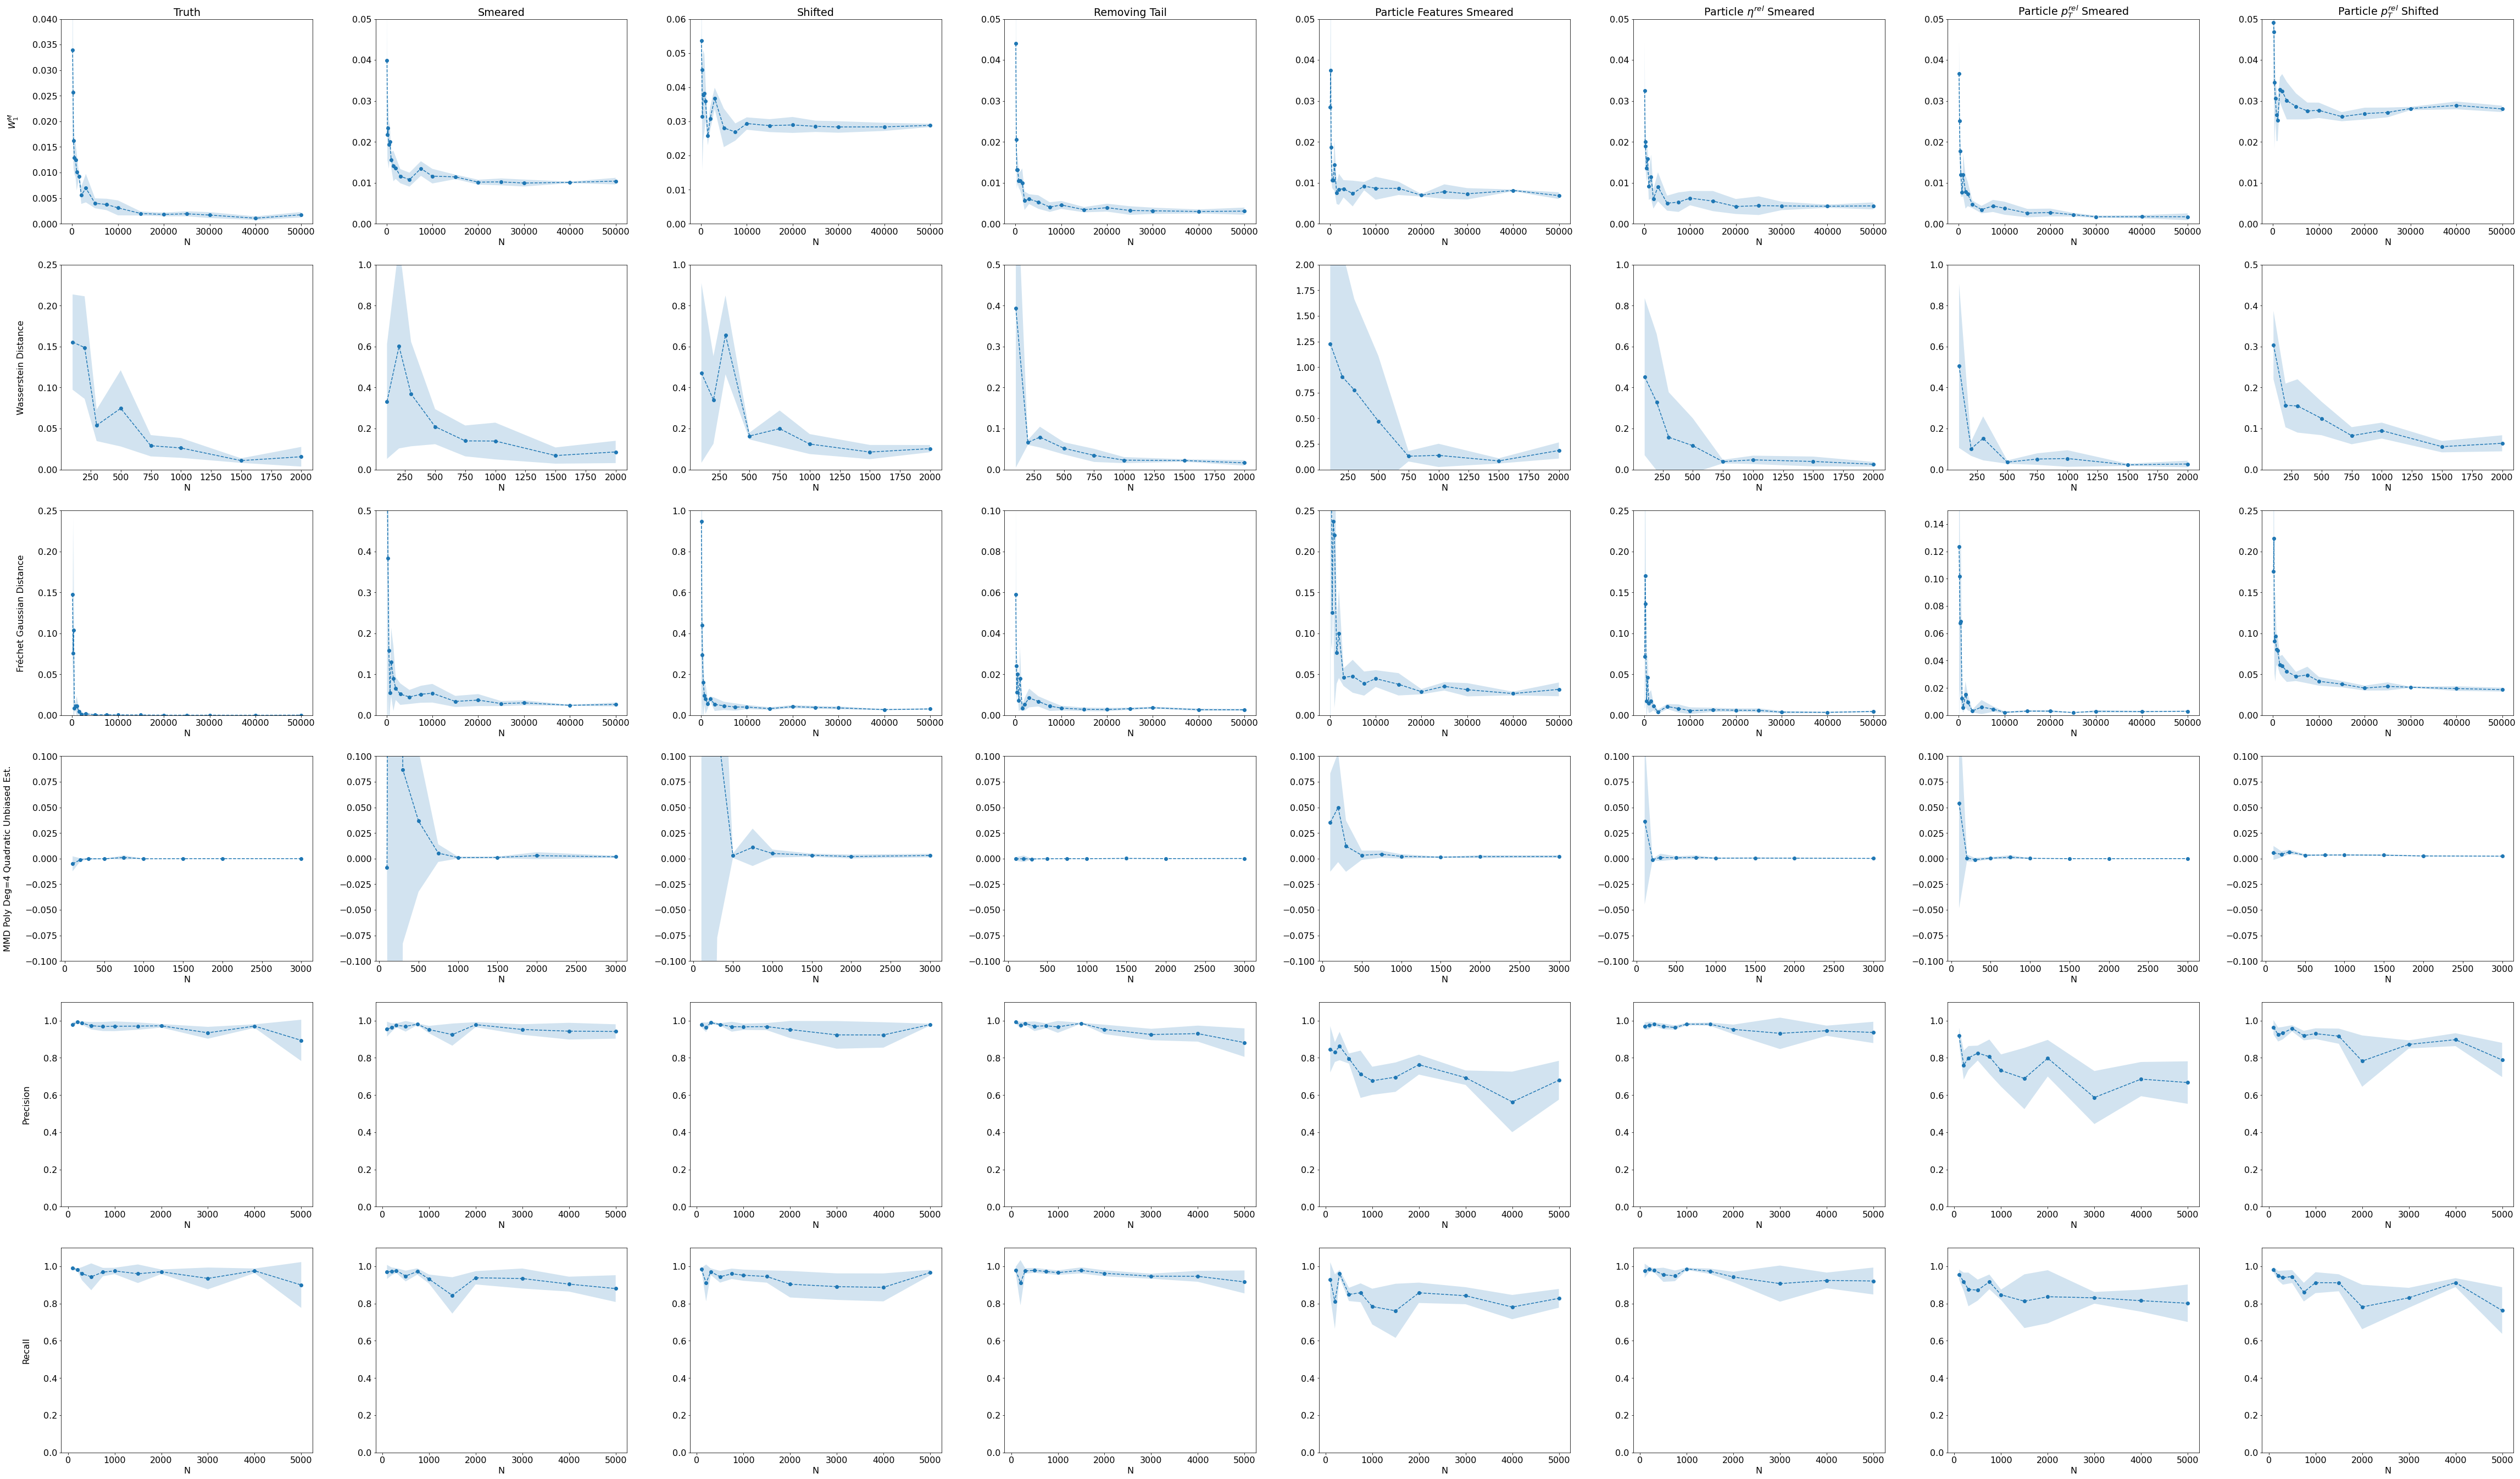

In [26]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("w1m", ([0, 0.04], [0, 0.05], [0, 0.06], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05])),
        ("wasserstein", ([0, 0.25], [0, 1], [0, 1], [0, 0.5], [0, 2], [0, 1], [0, 1], [0, 0.5])),
        (
            "fgd",
            ([0, 0.25], [0, 0.5], [0, 1], [0, 0.1], [0, 0.25], [0, 0.25], [0, 0.15], [0, 0.25]),
        ),
        (
            "mmdup4",
            (
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

i = 0
mkey = "w1m"
plotting.metric_label(axes[i][0], r"$W_1^M$")
for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
    axes[i][j].set_title(label)
    plotting.plot_means_stds(
        axes[i][j], measurements_w1m[dkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
    )

for k, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey in ["dc", "pr"]:
        continue

    i = k + 1

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_efps[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_efps[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )


plt.savefig(f"{plot_dir}/efps_scores.pdf", bbox_inches="tight")


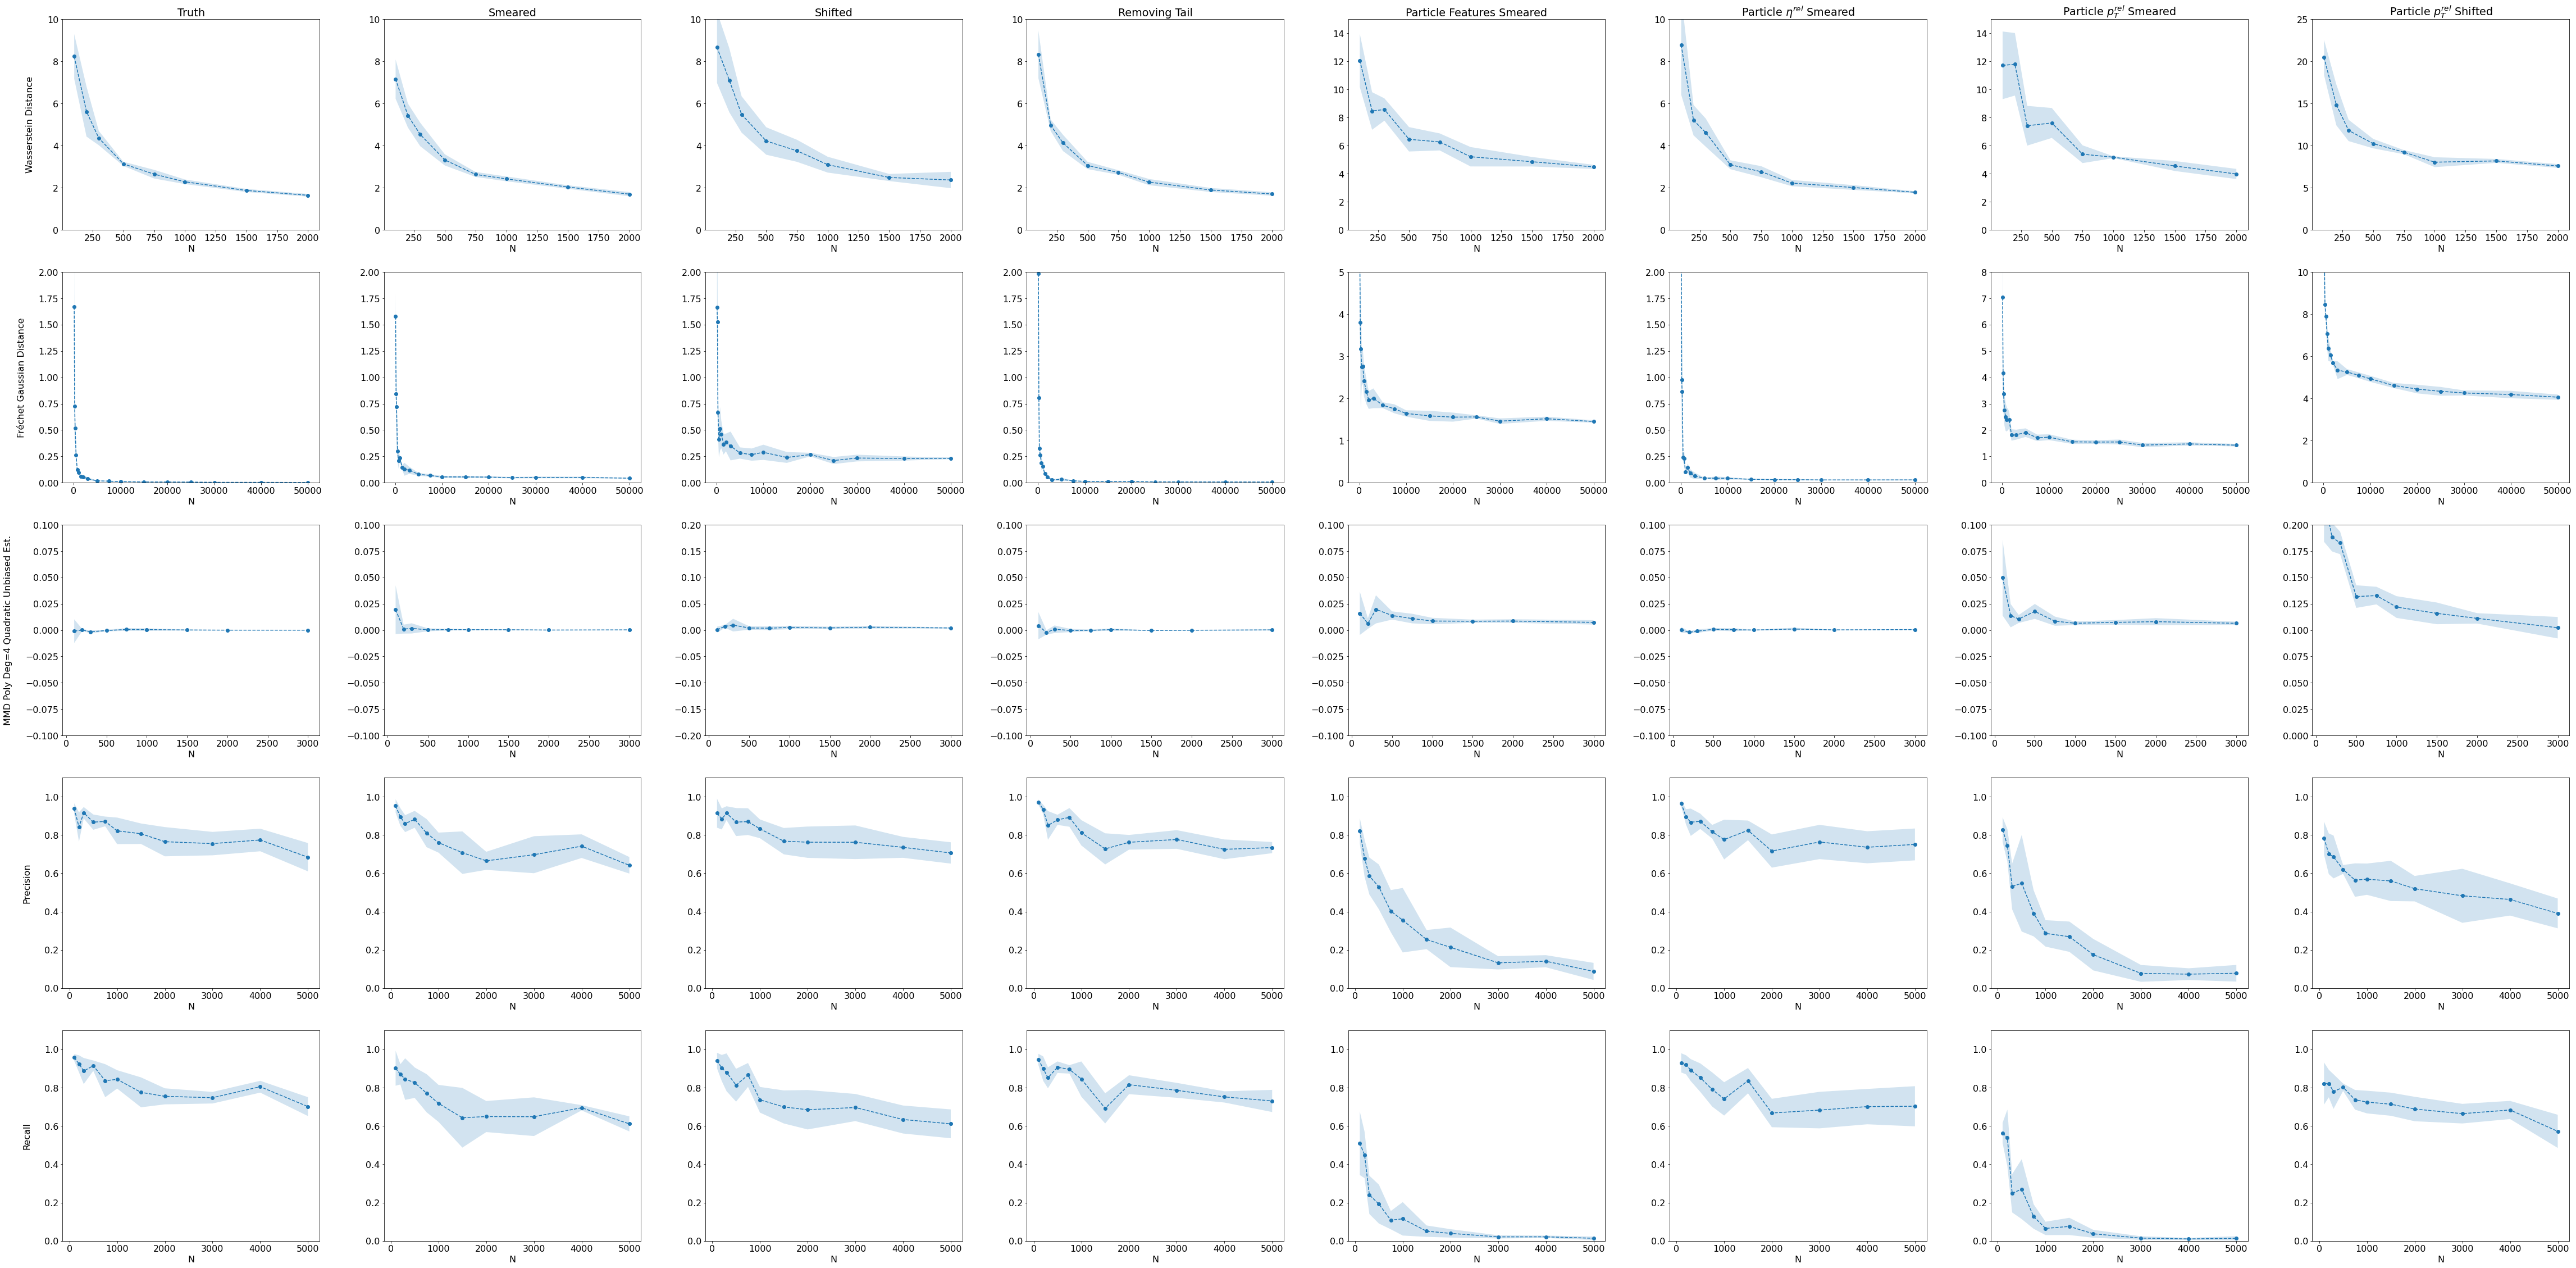

In [27]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 10], [0, 10], [0, 10], [0, 10], [0, 15], [0, 10], [0, 15], [0, 25])),
        ("fgd", ([0, 2], [0, 2], [0, 2], [0, 2], [0, 5], [0, 2], [0, 8], [0, 10])),
        (
            "mmdup4",
            (
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.2, 0.2],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [-0.1, 0.1],
                [0, 0.2],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey in ["dc", "pr"]:
        continue

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_acts[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_acts[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )

plt.savefig(f"{plot_dir}/acts_scores.pdf", bbox_inches="tight")


In [29]:
def print_mean_std(mean_stds: np.ndarray):
    return f"{mean_stds[0]:.3f} ± {mean_stds[1]:.3f}"

rows = []

row = [r"$W_1^M$"]
for dkey, values in measurements_w1m.items():
    row.append(print_mean_std(values['mean_std'][-1, :]))

rows.append(row)

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " EFP"]

            for dkey, values in measurements_efps.items():
                row.append(print_mean_std(values[mkey]['mean_std'][-1, :, i]))

            rows.append(row)
        # continue
    else:
        row = [label + " EFP"]

        for dkey, values in measurements_efps.items():
            row.append(print_mean_std(values[mkey]['mean_std'][-1, :]))

        rows.append(row)

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " PNet Activations"]

            for dkey, values in measurements_acts.items():
                row.append(print_mean_std(values[mkey]['mean_std'][-1, :, i]))

            rows.append(row)
        # continue
    else:
        row = [label + " PNet Activations"]

        for dkey, values in measurements_acts.items():
            row.append(print_mean_std(values[mkey]['mean_std'][-1, :]))

        rows.append(row)

results = pd.DataFrame(
    rows, columns=["Metric"] + list(np.array(list((dists | pf_dists).values()), dtype=object)[:, 1])
)

display(Markdown(results.to_markdown()))


|    | Metric                                                  | Truth          | Smeared       | Shifted       | Removing Tail   | Particle Features Smeared   | Particle $\eta^{rel}$ Smeared   | Particle $p_T^{rel}$ Smeared   | Particle $p_T^{rel}$ Shifted   |
|---:|:--------------------------------------------------------|:---------------|:--------------|:--------------|:----------------|:----------------------------|:--------------------------------|:-------------------------------|:-------------------------------|
|  0 | $W_1^M$                                                 | 0.002 ± 0.001  | 0.010 ± 0.001 | 0.029 ± 0.000 | 0.003 ± 0.001   | 0.007 ± 0.001               | 0.004 ± 0.001                   | 0.002 ± 0.001                  | 0.028 ± 0.001                  |
|  1 | Wasserstein Distance EFP                                | 0.016 ± 0.012  | 0.086 ± 0.054 | 0.102 ± 0.018 | 0.016 ± 0.007   | 0.186 ± 0.079               | 0.026 ± 0.011                   | 0.027 ± 0.016                  | 0.064 ± 0.020                  |
|  2 | Fréchet Gaussian Distance EFP                           | 0.000 ± 0.000  | 0.026 ± 0.005 | 0.031 ± 0.003 | 0.003 ± 0.000   | 0.032 ± 0.008               | 0.005 ± 0.001                   | 0.003 ± 0.000                  | 0.031 ± 0.002                  |
|  3 | MMD Poly Deg=4 Quadratic Unbiased Est. EFP              | -0.000 ± 0.000 | 0.002 ± 0.001 | 0.003 ± 0.002 | 0.000 ± 0.000   | 0.002 ± 0.001               | 0.000 ± 0.000                   | 0.000 ± 0.000                  | 0.002 ± 0.000                  |
|  4 | Precision EFP                                           | 0.894 ± 0.111  | 0.941 ± 0.039 | 0.978 ± 0.005 | 0.882 ± 0.077   | 0.680 ± 0.104               | 0.936 ± 0.057                   | 0.667 ± 0.114                  | 0.789 ± 0.092                  |
|  5 | Recall EFP                                              | 0.900 ± 0.123  | 0.881 ± 0.072 | 0.967 ± 0.015 | 0.916 ± 0.062   | 0.828 ± 0.050               | 0.921 ± 0.072                   | 0.802 ± 0.101                  | 0.763 ± 0.125                  |
|  6 | Wasserstein Distance PNet Activations                   | 1.646 ± 0.063  | 1.699 ± 0.096 | 2.372 ± 0.388 | 1.708 ± 0.082   | 4.492 ± 0.145               | 1.789 ± 0.050                   | 3.986 ± 0.362                  | 7.595 ± 0.219                  |
|  7 | Fréchet Gaussian Distance PNet Activations              | 0.002 ± 0.001  | 0.043 ± 0.003 | 0.232 ± 0.008 | 0.006 ± 0.002   | 1.453 ± 0.028               | 0.027 ± 0.005                   | 1.426 ± 0.047                  | 4.061 ± 0.123                  |
|  8 | MMD Poly Deg=4 Quadratic Unbiased Est. PNet Activations | -0.000 ± 0.000 | 0.000 ± 0.000 | 0.004 ± 0.001 | 0.000 ± 0.001   | 0.007 ± 0.002               | 0.001 ± 0.000                   | 0.006 ± 0.002                  | 0.102 ± 0.010                  |
|  9 | Precision PNet Activations                              | 0.684 ± 0.074  | 0.642 ± 0.043 | 0.706 ± 0.056 | 0.734 ± 0.029   | 0.088 ± 0.044               | 0.751 ± 0.083                   | 0.078 ± 0.043                  | 0.390 ± 0.078                  |
| 10 | Recall PNet Activations                                 | 0.701 ± 0.049  | 0.611 ± 0.039 | 0.612 ± 0.075 | 0.731 ± 0.058   | 0.014 ± 0.009               | 0.703 ± 0.105                   | 0.014 ± 0.011                  | 0.572 ± 0.087                  |